In [72]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut
import sys
from matplotlib.colors import LinearSegmentedColormap

system_name = 'ant_cons'
run_name = '2p_gamma_pcons1_b'
data_dir = 'data/' + system_name + '_multi/' + run_name + '/'
plot_dir = 'plots/' + system_name + '_multi/' + run_name + '/'

### Importing the paramters

In [73]:
par_info = ut.read_params(data_dir+'info.txt')
par_env0 = ut.read_params(data_dir+'param_env_0.txt')
print(par_info)

{'counts': 64.0, 'p_consume': array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        ]), 'gamma': array([0.999     , 0.99772415, 0.99482053, 0.98821231, 0.97317304,
       0.93894598, 0.86105045, 0.68377223]), 'multi': array(['p_consume', 'gamma'], dtype='<U9')}


### Importing the data

In [74]:
forager_p = np.zeros((int(par_info['counts']), int(par_env0['max_k'])))
recipient_p = np.zeros((int(par_info['counts']), int(par_env0['max_k'])-1))
average_steps = 1000
return_for, return_rec = np.zeros(int(par_info['counts'])), np.zeros(int(par_info['counts']))
ep_time = np.zeros(int(par_info['counts']))
gammas, pcons = [], []
for i in range(int(par_info['counts'])):
    l_forag = ut.read_traj(data_dir+str(i)+'_best_policy_0.txt', False)[1:int(par_env0['max_k'])+1]
    l_rec = ut.read_traj(data_dir+str(i)+'_best_policy_1.txt', False)[1:int(par_env0['max_k'])+1]
    penv = ut.read_params(data_dir+'param_env_'+str(i)+'.txt')
    palg = ut.read_params(data_dir+'param_alg_'+str(i)+'.txt')
    gammas.append(palg['gamma'])
    pcons.append(penv['p_consume'])
    forager_p[i] = np.array(l_forag)[:,0]
    recipient_p[i] = np.array(l_rec)[:-1,0]
    ret_traj, h = ut.read_traj(data_dir+str(i)+'_return_traj.txt')
    ep_time[i] = np.mean(ret_traj[len(ret_traj)-average_steps:,0])
    return_for[i] = np.mean(ret_traj[len(ret_traj)-average_steps:,1])
    return_rec[i] = np.mean(ret_traj[len(ret_traj)-average_steps:,2])
    sys.stdout.write("\rImported files: {}/{}".format(i+1, int(par_info['counts'])))
    sys.stdout.flush()

Imported files: 64/64

### How much policy are deterministic?
Just a visual representation

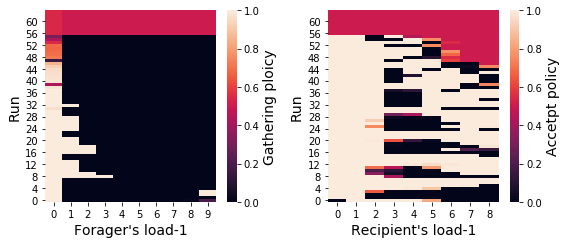

In [75]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3.5))
      
sns.heatmap(forager_p, ax=ax1)
ax1.invert_yaxis()
ax1.set_ylabel('Run', fontsize=14)
ax1.set_xlabel('Forager\'s load-1', fontsize=14)
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Gathering ploicy', fontsize=14)

sns.heatmap(recipient_p, ax=ax2)
ax2.invert_yaxis()
ax2.set_ylabel('Run', fontsize=14)
ax2.set_xlabel('Recipient\'s load-1', fontsize=14)
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Accetpt policy', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir + 'policies.png', dpi=200)

In [76]:
n_gath_flat = [np.sum(p>0.5) for p in forager_p]
n_acc_flat = [np.sum(p>0.5) for p in recipient_p]
gamma_set = np.sort(list(set(gammas)))
pcons_set = np.sort(list(set(pcons)))
n_gath_mat = np.zeros((len(gamma_set), len(pcons_set)))
n_acc_mat = np.zeros((len(gamma_set), len(pcons_set)))
log_ret_for_mat = np.zeros((len(gamma_set), len(pcons_set)))
log_ret_rec_mat = np.zeros((len(gamma_set), len(pcons_set)))
ep_len_mat = np.zeros((len(gamma_set), len(pcons_set)))

for k in range(len(n_gath_flat)):
    g, pc = gammas[k], pcons[k]
    j = np.where(gamma_set == gammas[k])[0][0]
    i = np.where(pcons_set == pcons[k])[0][0]
    n_gath_mat[i,j] = n_gath_flat[k]
    n_acc_mat[i,j] = n_acc_flat[k]
    ret_for_mat[i,j] = np.log(return_for[k]) if return_for[k]>0 else 0
    ret_rec_mat[i,j] = np.log(return_rec[k]) if return_rec[k]>0 else 0
    ep_len_mat[i,j] = ep_time[k]

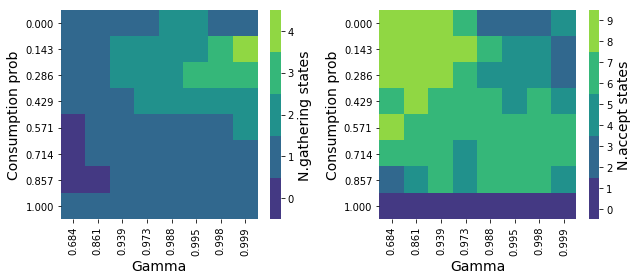

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))
cmap = sns.color_palette("viridis", max(n_gath_flat)+1)

sns.heatmap(n_gath_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
colorbar = ax1.collections[0].colorbar
delta = max(n_gath_flat)/(max(n_gath_flat)+1)
tics = [delta*i+ delta/2 for i in range(max(n_gath_flat)+1)]
colorbar.set_ticks(tics)
colorbar.set_ticklabels(np.arange(max(n_gath_flat)+1))
colorbar.set_label('N.gathering states', fontsize=14)

sns.heatmap(n_acc_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
ax2.set_ylabel('Consumption prob', fontsize=14)
ax2.set_xlabel('Gamma', fontsize=14)
colorbar = ax2.collections[0].colorbar
delta = max(n_acc_flat)/(max(n_acc_flat)+1)
tics = [delta*i+ delta/2 for i in range(max(n_acc_flat)+1)]
colorbar.set_ticks(tics)
colorbar.set_ticklabels(np.arange(max(n_acc_flat)+1))
colorbar.set_label('N.accept states', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir + 'param_space.png', dpi=200)

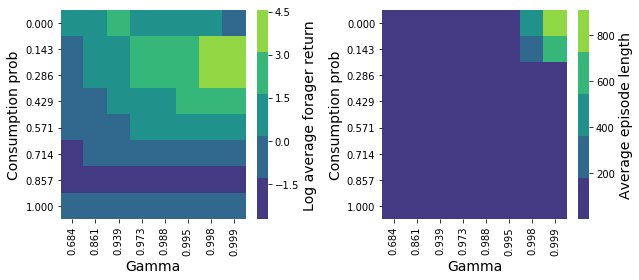

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))
cmap = sns.color_palette("viridis", max(n_gath_flat)+1)

sns.heatmap(ret_for_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Log average forager return', fontsize=14)

sns.heatmap(ep_len_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
ax2.set_ylabel('Consumption prob', fontsize=14)
ax2.set_xlabel('Gamma', fontsize=14)
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Average episode length', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir + 'param_space.png', dpi=200)